# Tilt Compensated Compass

Kevin Walchko

7 July 2019

---

A tilt-compensated compass or eCompass uses an accerlometer to determine the mangnetometer's orientation in 3D space and correct any detected tilt. Thus, the compass acks like it is always laying on a flat table with respect to the Earth's magnetic field.

Steps:

1. Determine a magnetometer bias based off a data set where we tumbled the sensor around in 3D space.
2. Determine the accelerometer bias based off the sensor sitting still on a table for a period of time
3. Using the still data set, correct both the magnetometer and acceleration data for the determined biases
4. Run the compass program and see what it gets
    1. Since the sensor is sitting still on a table, the answer should be: roll=pitch=0 and heading=240 degs

## References

- [AN4248 Implementing a Tilt-Compensated eCompass using an Accelerometer and Magnetometer Sensors](https://www.nxp.com/files-static/sensors/doc/app_note/AN4248.pdf)

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import the_collector
from the_collector import BagIt, Pickle, Data
from matplotlib import pyplot as plt

In [7]:
def apply_calibration(data, bias):
    """
    Given the data and the bias, correct the data 
    """
    c_data = []
    for d in data:
        t = []
        for i in [0,1,2]:
            t.append(d[i]-bias[i])
        c_data.append(t)
            
    return c_data

In [8]:
def find_still_calibration(a, ref):
    # we expect to see [0,0,1] for acceleration, so we will find the 
    # average offset from
    # that value and use it as the bias ... this is far from the best
    # way to do this in the real world.
    xx = np.mean([x[0] for x in a])
    yy = np.mean([x[1] for x in a])
    zz = np.mean([x[2] for x in a])
    
    return (xx - ref[0], yy - ref[1], zz - ref[2],)

In [5]:
def find_mag_calibration(mag):
    """
    Go through the raw data and find the max/min for x, y, z
    """
    max_m = [-1000]*3
    min_m = [1000]*3
    for m in mag:
        for i in range(3):
            max_m[i] = m[i] if m[i] > max_m[i] else max_m[i]
            min_m[i] = m[i] if m[i] < min_m[i] else min_m[i]
    bias = [0]*3
    for i in range(3):
        bias[i] = (max_m[i] + min_m[i])/2
    return bias

In [12]:
# use the tumble data to get a good bias for the magnetometers.
# It turns out, that you want to understand the Earth's magnetic
# field in all orientations and determine a bias from that. We will
# calibrate the accelerometer differently
bag = BagIt(Pickle)
cal = bag.read('data-tumble.pickle.bag')
mag = [x.data for x in cal['mag']]
m_bias = find_mag_calibration(mag)

>>  pickle
>> Reading[pickle]: data-tumble.pickle.bag


In [9]:
# get the still data
still_cal = bag.read('data-still.pickle.bag')

# get and correct acceleration data
sa = [x.data for x in still_cal['accel']]
a_bias = find_still_calibration(sa, (0,0,1))
csa = apply_calibration(sa, a_bias)

# get and correct the magnetometer data, but notice we are
# using the bias that was detected from the tumble data set
sm = [x.data for x in still_cal['mag']]
csm = apply_calibration(sm, m_bias)

>> Reading[pickle]: data-still.pickle.bag


In [13]:
# If your magnetometer is always flat, then you will get a good reading. However,
# if your magnetometer tilts, then you use the accelerometer to account for
# orientation of the magnetometer when reading the Earth's magnetic field, so you
# get an accurate reading.
from ins_nav import TiltCompensatedCompass as TCC

saver = []
savep = []
saveh = []

t = list(1/200 * np.array(list(range(len(csm)))))

tcc = TCC()
for a,m in zip(csa, csm):
    r,p,h = tcc.compensate(a,m)
    saver.append(r)
    savep.append(p)
    saveh.append(h)

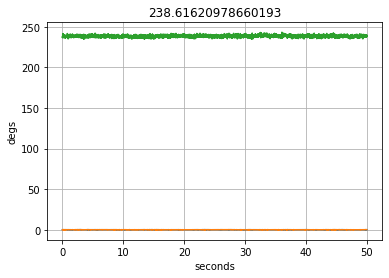

In [14]:
# The data was collected with the compass sitting flat on a
# table. Thus, roll = pitch = 0 and heading should be around
# the 240 degs (without accounting for declination angle).
plt.plot(t, saver, label='roll')
plt.plot(t, savep, label='pitch')
plt.plot(t, saveh, label='heading')
plt.grid(True)
plt.ylabel("degs")
plt.xlabel("seconds")
plt.title(np.mean(saveh));

# Conclusion

We end up with what we want: roll=pitch=0 and heading=240 (really close) ... **success!** 

The acceration calibration was only done in the z-axis direction. For better performance, it should be done in x, y, and z axis directions (both positive and negative) and couple axis x-y, x-z, and y-z directions (basically tilt the sensor so gravity is on both axes at the same time).